In [2]:
import sys
assert sys.version_info >= (3,7)

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pandas as pd
from math import floor

## Define functions

In [8]:
def plot_image(img, title=None, img2=None, title2=None):
    """
    function to display two images side by side
    img = image to display
    title = title for image one
    img2 = second image, optional
    title2 = title for image two, optional
    """
    if img2 is None:
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.xticks([]), plt.yticks([])
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title(title)
        ax[1].imshow(img2, cmap='gray')
        ax[1].set_title(title2)
        ax[0].set_axis_off()
        ax[1].set_axis_off()

def load_image_single(img_path, data, img_name=None, random=True):
    """
    function to load a single image, return the image in RGB and the ground truth in x1, y1, x2, y2
    img_path: the path of the folder that contains the images
    data: annotation in pandas dataframe
    img_name: the name of the image, default to None
    random: set this to True then a random image in the file path will be loaded, default to True
    """
    if random:
        idx = np.random.randint(0, len(data))
        img = cv.imread(img_path + "/" + data.iloc[idx]['filename'])
        print(data.iloc[idx]['filename'])
        x1 = data.iloc[idx]['x1']
        y1 = data.iloc[idx]['y1']
        x2 = data.iloc[idx]['x2']
        y2 = data.iloc[idx]['y2']
        return cv.cvtColor(img, cv.COLOR_BGR2RGB), (x1, y1, x2, y2)
    else:
        idx = data.index[data['filename'] == img_name]
        img = cv.imread(img_path + "/" + data.iloc[idx]['filename'].values[0])
        x1 = data.iloc[idx]['x1'].values[0]
        y1 = data.iloc[idx]['y1'].values[0]
        x2 = data.iloc[idx]['x2'].values[0]
        y2 = data.iloc[idx]['y2'].values[0]
        return cv.cvtColor(img, cv.COLOR_BGR2RGB), (x1, y1, x2, y2)
        
def load_image(img_path, data):
    """
    function to load all the images in the path, return a list of images in RGB and the ground truths in x1, y1, x2, y2
    img_path: the path of the folder that contains the images
    data: annotation in pandas dataframe
    """
    imgs = []
    bbs = []
    names = []
    for i in range(len(data)):
        img = cv.imread(img_path + "/" + data.iloc[i]['filename'])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        imgs.append(img)
        x1 = data.iloc[i]['x1']
        y1 = data.iloc[i]['y1']
        x2 = data.iloc[i]['x2']
        y2 = data.iloc[i]['y2']
        bbs.append((x1, y1, x2, y2))
        names.append(data.iloc[i]['filename'])
    return imgs, bbs, names

def preprocess(img, bb, width):
    """
    Resize the image and apply bilateral filter, return the resized image and ground truth bounding box
    bb: bounding box in x1, y1, x2, y2
    """
    factor = width / img.shape[1]
    img_resize = cv.resize(img, None, fx=factor, fy=factor)
    img_smooth = cv.bilateralFilter(img_resize, 5, 75, 150)
    
    # scale the bounding box according to the  factor
    x1 = floor(bb[0] * factor)
    y1 = floor(bb[1] * factor)
    x2 = floor(bb[2] * factor)
    y2 = floor(bb[3] * factor)
    return img_smooth, (x1, y1, x2, y2)

def thresholding_pipeline(img, th_type=cv.ADAPTIVE_THRESH_GAUSSIAN_C, th_bsize=7, th_c=0, open_kernel=3):
    """
    Convert to grayscale, perform CLAHE, thresholding, morphological operation, find the contour and then return bounding box in x1,y1,x2,y2
    img: image in RGB
    th_type: default to thresh_gaussian_c
    th_bsize: blockSize for thresholding, default to 7
    th_c: constant in thresholding, default to 0
    open_kernel: size of kernel for morphological opening, default to 3
    """
    # convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    # clahe
    clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(5,5))
    img_clahe = clahe.apply(img_gray)
    
    # thresholding
    th = cv.adaptiveThreshold(img_clahe, 255, th_type, cv.THRESH_BINARY_INV, th_bsize, th_c)
    
    # morphological opening
    kernel = np.ones((open_kernel,open_kernel),np.uint8)
    img_open = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
    
    # find the contours and calculate bounding box
    contours, hierarchy = cv.findContours(img_open, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # if no contours
    if(len(contours) == 0):
        return (0, 0, 0, 0)
    
    contourAreaList = []
    for contour in contours:
        area = cv.contourArea(contour)
        contourAreaList.append(area)
    x, y, w, h = cv.boundingRect(contours[contourAreaList.index(max(contourAreaList))])
    return (x, y, x+w, y+h)

def thresholding_visualization(img, th_type=cv.ADAPTIVE_THRESH_GAUSSIAN_C, th_bsize=7, th_c=0, open_kernel=3):
    """
    Convert to grayscale, perform CLAHE, thresholding, morphological operation, find the contour
    Plot the result of each stage for visualization
    img: image in RGB
    th_type: default to thresh_gaussian_c
    th_bsize: blockSize for thresholding, default to 7
    th_c: constant in thresholding, default to 0
    open_kernel: size of kernel for morphological opening, default to 3 
    """
    plt.figure(figsize=(10, 10))
    # convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    plt.subplot(321), plt.imshow(img_gray, cmap=plt.cm.gray), plt.title("Grayscale")
    plt.xticks([]), plt.yticks([])
    
    # clahe
    clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(5,5))
    img_clahe = clahe.apply(img_gray)
    plt.subplot(322), plt.imshow(img_clahe, cmap=plt.cm.gray), plt.title("CLAHE")
    plt.xticks([]), plt.yticks([])
    
    # thresholding
    th = cv.adaptiveThreshold(img_clahe, 255, th_type, cv.THRESH_BINARY_INV, th_bsize, th_c)
    plt.subplot(323), plt.imshow(th, cmap=plt.cm.gray), plt.title("Threshold")
    plt.xticks([]), plt.yticks([])
    
    # morphological opening
    kernel = np.ones((open_kernel,open_kernel),np.uint8)
    img_open = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
    plt.subplot(324), plt.imshow(img_open, cmap=plt.cm.gray), plt.title("Morphological Opening")
    plt.xticks([]), plt.yticks([])
    
    # find the contours and visualize segemented image
    contours, hierarchy = cv.findContours(img_open, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contourAreaList = []
    if(len(contours) != 0):
        img_copy = img.copy()
        cv.drawContours(img_copy, contours, -1, (255, 0, 0), 2)
        plt.subplot(325), plt.imshow(img_copy, cmap=plt.cm.gray), plt.title("Contour")
        plt.xticks([]), plt.yticks([])
        
        mask = img_open.copy()
        contour = sorted(contours, key=cv.contourArea, reverse=True)[0]
        cv.drawContours(mask, [contour], 0, (255, 255, 255), -1)

    plt.show()

def computeIOU(boxA, boxB):
    """
    Args: in (x1, y1, x2, y2)
    """
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    #max is to prevent negative value when two box does not overlap
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    #area of A and area of B
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA+areaB - interArea)

## Read the annotation as pandas dataframe

In [9]:
img_path = "tsrd-train"
annotation = "TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt"
header = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class']
if os.path.isfile(annotation):
    data = pd.read_csv(annotation, sep=';', header=None, index_col=False, names=header)
    print(data.head())
    print('Number of images: ', len(data))
else:
    print('File do not exist')

       filename  width  height  x1  y1   x2   y2  class
0  000_0001.png    134     128  19   7  120  117      0
1  000_0002.png    165     151  23  12  149  138      0
2  000_0003.png    128     122  22  14  116  105      0
3  000_0010.png     80      73  14   8   67   63      0
4  000_0011.png    186     174  36  15  155  157      0
Number of images:  4170


## Parameter Tuning

In [5]:
# load all the images
imgs, bbs, names = load_image(img_path=img_path, data=data)

In [48]:
# generate combination of different parameter values
import itertools
param_list = [[3, 5, 7, 9], [0, 3, 5], [3, 5, 7]]
param_list = list(itertools.product(*param_list))
print(len(param_list))

36


In [49]:
# loop through the parameter combinations, and calculate the number of successful segmentation for each combination
# take some time to run

no_of_success = []
for param in param_list:
    iou_th = 0.55
    ious = []
    for i in range(len(imgs)):
        img, gt_bb = preprocess(imgs[i], bbs[i], 100)
        result_bb = thresholding_pipeline(img, th_bsize=param[0], th_c=param[1], open_kernel=param[2])
        iou = computeIOU(result_bb, gt_bb)
        ious.append(iou)

    ious_np = np.array(ious)
    success_iou = ious_np[ious_np > iou_th]
    no_of_success.append(success_iou.shape[0])

In [50]:
highest_no = max(no_of_success)
best_param = param_list[no_of_success.index(highest_no)]
print(highest_no)
print(best_param)

3620
(7, 0, 3)


The best parameter setting would be 7 for th_bsize, 0 for th_c and 3 for morphological opening kernel size
<br>Successfully segmented 3620 images

## Visualize the result in different stage

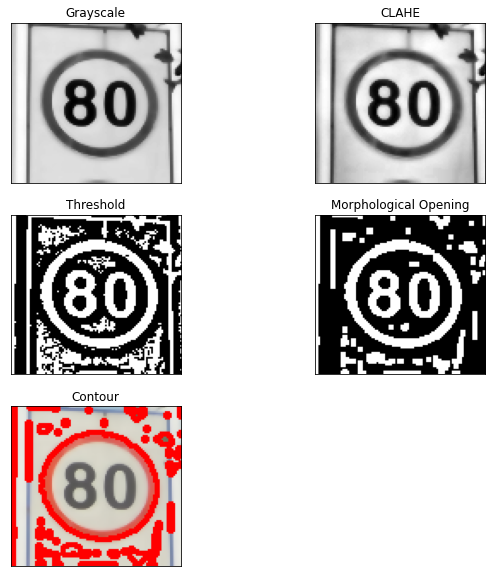

In [14]:
#img, gt_bb = load_image_single(img_path, data)
img, gt_bb = load_image_single(img_path, data, img_name="007_1_0044.png", random=False)
img, gt_bb = preprocess(img, gt_bb, 100)
thresholding_visualization(img)

## Run all the images through the pipeline

In [11]:
ious = []
gt_bbs = []
result_bbs = []
for i in range(len(imgs)):
    img, gt_bb = preprocess(imgs[i], bbs[i], 100)
    result_bb = thresholding_pipeline(img)
    iou = computeIOU(result_bb, gt_bb)
    ious.append(iou)
    result_bbs.append(result_bb)
    gt_bbs.append(gt_bb)

In [12]:
iou_th = 0.55

# convert to numpy array
ious_np = np.array(ious)
names_np = np.array(names)
result_bbs_np = np.array(result_bbs)
gt_bbs_np = np.array(gt_bbs)

success_iou = ious_np[ious_np > iou_th]
success_name = names_np[ious_np > iou_th]
success_bbs = result_bbs_np[ious_np > iou_th]
success_gt = gt_bbs_np[ious_np > iou_th]

# sort according to the IOU in descending order
sortIdx = success_iou.argsort()[::-1]
success_iou = success_iou[sortIdx]
success_name = success_name[sortIdx]
success_bbs = success_bbs[sortIdx]
success_gt = success_gt[sortIdx]

In [207]:
print(success_name.shape)
print(success_gt.shape)
print(success_bbs.shape)
print(success_iou.shape)

(3620,)
(3620, 4)
(3620, 4)
(3620,)


### Select 100 images with highest IOU

In [208]:
resultDF = pd.DataFrame()
resultDF.insert(0, "Filename", success_name[0:100])
resultDF.insert(1, "P_x1", success_bbs[:100, 0])
resultDF.insert(2, "P_y1", success_bbs[:100, 1])
resultDF.insert(3, "P_x2", success_bbs[:100, 2])
resultDF.insert(4, "P_y2", success_bbs[:100, 3])
resultDF.insert(5, "GT_x1", success_gt[:100, 0])
resultDF.insert(6, "GT_y1", success_gt[:100, 1])
resultDF.insert(7, "GT_x2", success_gt[:100, 2])
resultDF.insert(8, "GT_y2", success_gt[:100, 3])
resultDF.insert(9, "IOU", success_iou[:100])

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(resultDF)

              Filename  P_x1  P_y1  P_x2  P_y2  GT_x1  GT_y1  GT_x2  GT_y2       IOU
0         035_0064.png    10    11    90    78     10     11     90     78  1.000000
1         012_0011.png    13    14    85    83     13     14     85     83  1.000000
2       007_1_0050.png    10     7    86    78     10      7     86     78  1.000000
3       007_1_0044.png    17    15    86    79     17     15     86     79  1.000000
4         005_0060.png    10     5    92    82     10      5     92     82  1.000000
5         056_0016.png    14    10    82    77     14     10     82     77  1.000000
6       034_1_0002.png    15    14    88    77     15     14     88     77  1.000000
7         043_0035.png    21    21    86    72     21     21     86     72  1.000000
8       007_1_0018.png    11     5    92    86     11      5     92     86  1.000000
9         006_0014.png    18     8    82    86     18      8     82     86  1.000000
10      006_1_0014.png    18     8    82    86     18      8     

## Visualize with single image

0.6481814908174289


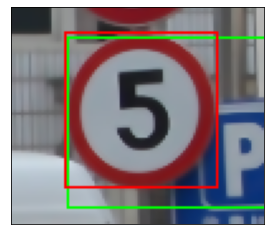

In [15]:
# change the img_name to pass in different images
img, gt_bb = load_image_single(img_path, data, img_name= "000_0042.png", random=False)
img, gt_bb = preprocess(img, gt_bb, 100)
result_bb = thresholding_pipeline(img)

img_copy = img.copy()
cv.rectangle(img_copy, (result_bb[0],result_bb[1]), (result_bb[2],result_bb[3]), (0,255,0), 1)
cv.rectangle(img_copy, (gt_bb[0],gt_bb[1]), (gt_bb[2],gt_bb[3]), (255,0,0), 1)
plot_image(img_copy)

print(computeIOU(result_bb, gt_bb))

030_0055.png
IOU:  0.5188679245283019


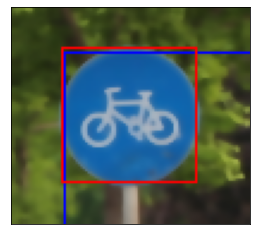

In [16]:
# randomly load an image
img, gt_bb = load_image_single(img_path, data)
img, gt_bb = preprocess(img, gt_bb, 100)
result_bb = thresholding_pipeline(img)

img_copy = img.copy()
cv.rectangle(img_copy, (result_bb[0],result_bb[1]), (result_bb[2],result_bb[3]), (0,0,255), 1)
cv.rectangle(img_copy, (gt_bb[0],gt_bb[1]), (gt_bb[2],gt_bb[3]), (255,0,0), 1)
plot_image(img_copy)

print("IOU: ",computeIOU(result_bb, gt_bb))

## Test on External Dataset

### data set taken from Kaggle:
https://www.kaggle.com/datasets/andrewmvd/road-sign-detection?resource=download

In [166]:
!pip install beautifulsoup4
!pip install lxml

In [29]:
# import library for reading xml file

from bs4 import BeautifulSoup as bs

Ground truth:  (11, 27, 55, 71)
Predicted:  (12, 28, 56, 69)
IOU:  0.8940493468795355


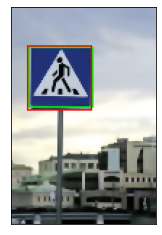

In [204]:
ex_anno_path = "extra_annotations"
ex_img_path = "extra_images"

img_name = "road143.png"
img = cv.imread(ex_img_path + "/" + img_name)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
anno = "road143.xml"
with open((ex_anno_path+"/"+anno), 'r') as f:
    ex_data = f.read()
    
Bs_data = bs(ex_data, "xml")
x1 = int(Bs_data.find("xmin").text)
y1 = int(Bs_data.find("ymin").text)
x2 = int(Bs_data.find("xmax").text)
y2 = int(Bs_data.find("ymax").text)
gt_bb = (x1, y1, x2, y2)

img, gt_bb = preprocess(img, gt_bb, 100)
result_bb = thresholding_pipeline(img)
img_copy = img.copy()
cv.rectangle(img_copy, (result_bb[0],result_bb[1]), (result_bb[2],result_bb[3]), (0,255,0), 1)
cv.rectangle(img_copy, (gt_bb[0],gt_bb[1]), (gt_bb[2],gt_bb[3]), (255,0,0), 1)
plot_image(img_copy)

print("Ground truth: ", gt_bb)
print("Predicted: ", result_bb)
print("IOU: ",computeIOU(result_bb, gt_bb))

## Runtime evaluation

### Threshold method

In [179]:
import time

start=time.time()

img, gt_bb = load_image_single(img_path, data, img_name="054_1_0083.png", random=False)
img, gt_bb = preprocess(img, gt_bb, 100)
result_bb = thresholding_pipeline(img)
print("IOU: ", computeIOU(result_bb, gt_bb))

end = time.time()
print("Time to segment a image: ",end-start)

IOU:  0.9864864864864865
Time to segment a image:  0.004000186920166016
